In [1]:
import numpy as np
import phate
import scprep, scanpy
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import pearsonr
import pandas as pd
import leidenalg

In [2]:
names = ['GSPA_QR', 'DiffusionEMD', 'MAGIC', 'Signals', 'GSPA', 'GAE_att_Ggene',
       'GAE_noatt_Ggene', 'Node2Vec_Ggene', 'Eigenscore', 'GFMMD', 'SIMBA', 'siVAE']

In [3]:
trajectory_data = np.load('../data/splatter_simulated_data.npz')
data = trajectory_data['data']
true_counts = trajectory_data['true_counts']
true_lib_size = true_counts.T.sum(axis=1)

In [4]:
time = trajectory_data['pseudotime'] / 10000

In [6]:
cell_phate_op = phate.PHATE(random_state=1234, verbose=False)
true_cell_data_phate = cell_phate_op.fit_transform(true_counts)

In [8]:
true_cell_data_phate = true_cell_data_phate * [-1, 1]
adata = scanpy.AnnData(true_counts)

## Gene clusters for all approaches

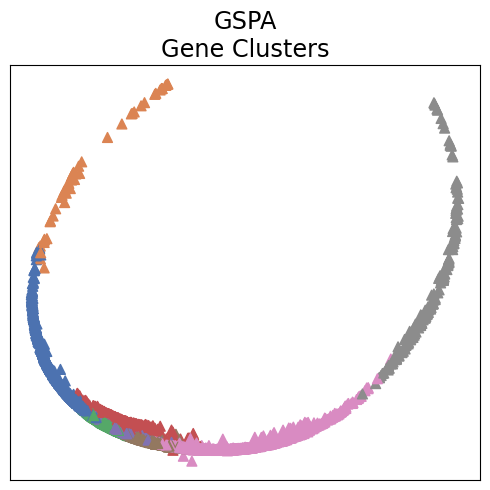

<Figure size 640x480 with 0 Axes>

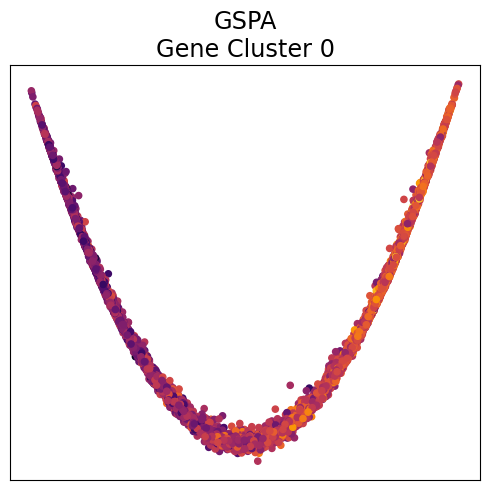

<Figure size 640x480 with 0 Axes>

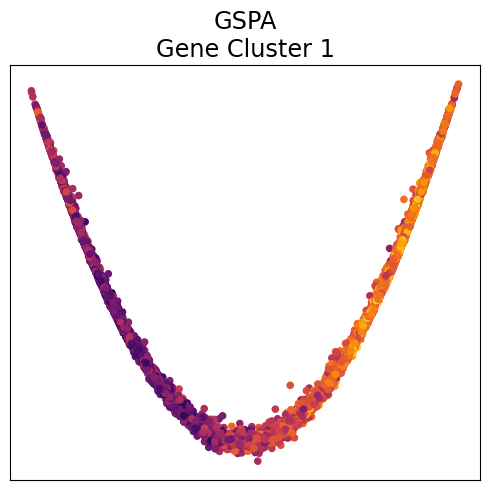

<Figure size 640x480 with 0 Axes>

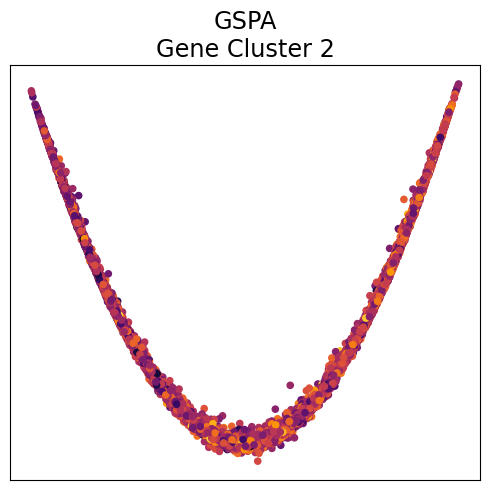

<Figure size 640x480 with 0 Axes>

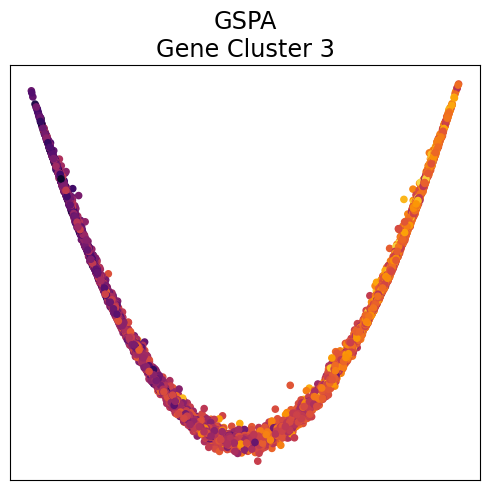

<Figure size 640x480 with 0 Axes>

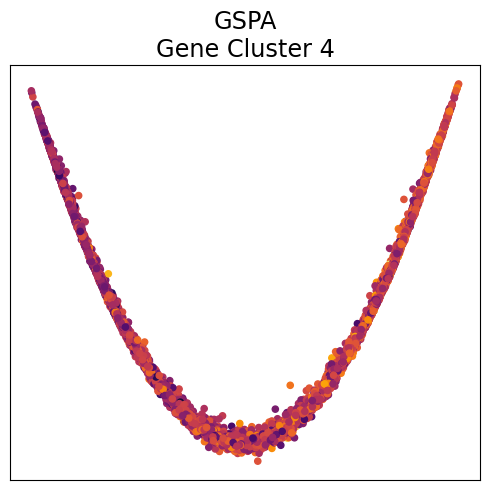

<Figure size 640x480 with 0 Axes>

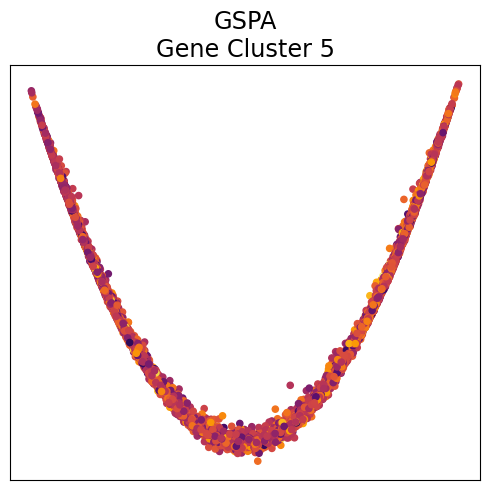

<Figure size 640x480 with 0 Axes>

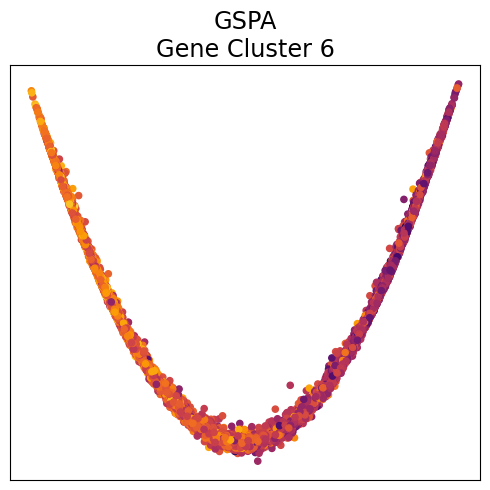

<Figure size 640x480 with 0 Axes>

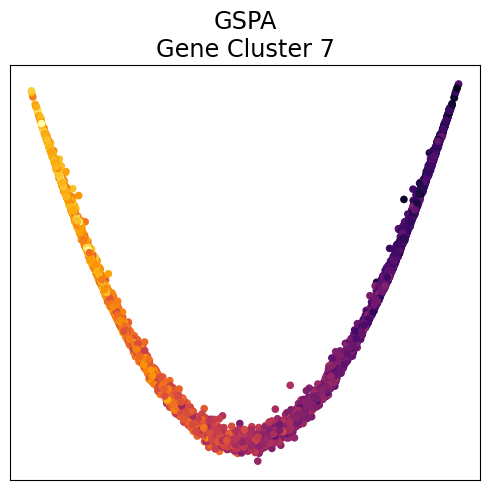

<Figure size 640x480 with 0 Axes>

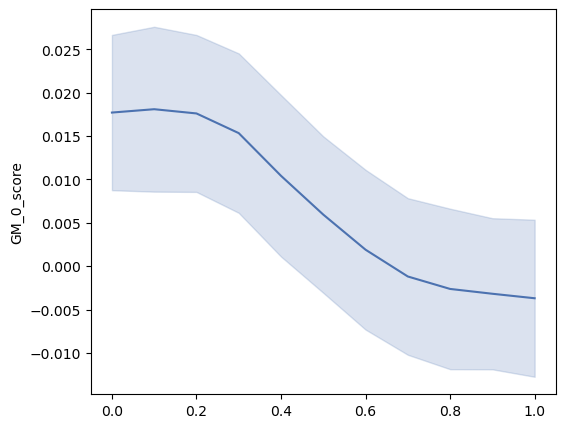

<Figure size 640x480 with 0 Axes>

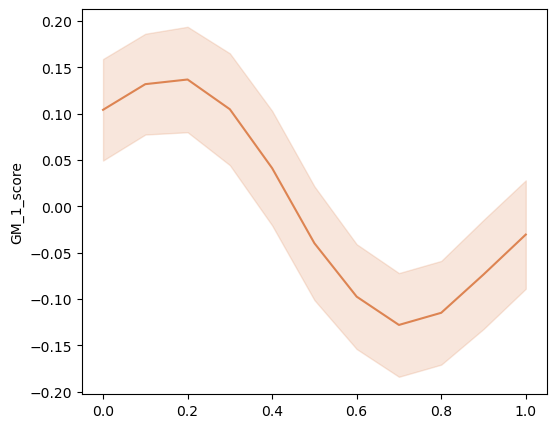

<Figure size 640x480 with 0 Axes>

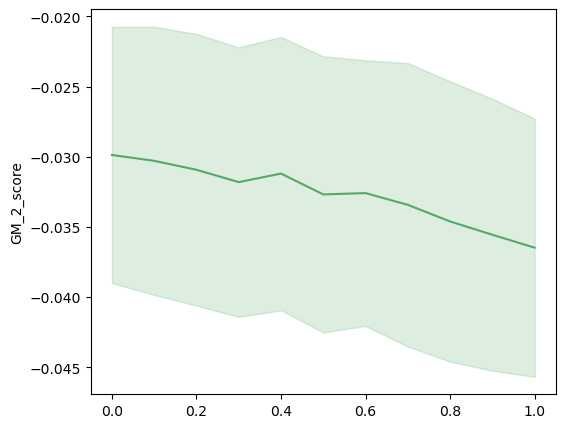

<Figure size 640x480 with 0 Axes>

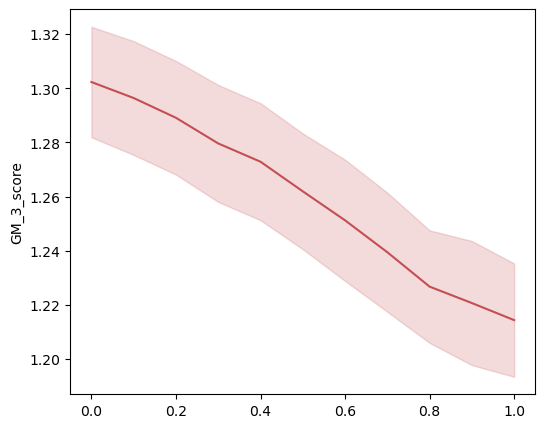

<Figure size 640x480 with 0 Axes>

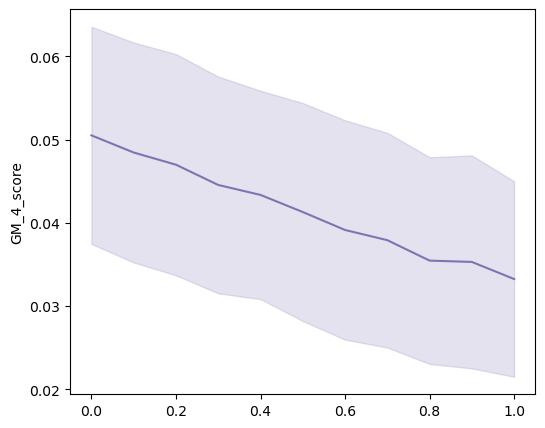

<Figure size 640x480 with 0 Axes>

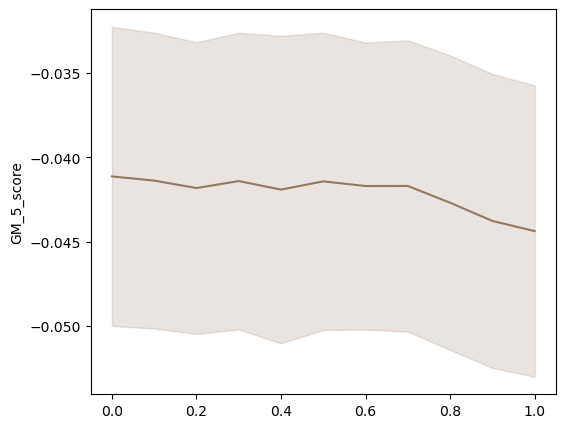

<Figure size 640x480 with 0 Axes>

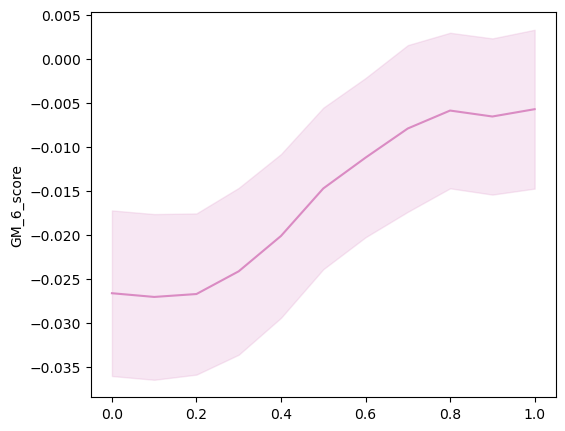

<Figure size 640x480 with 0 Axes>

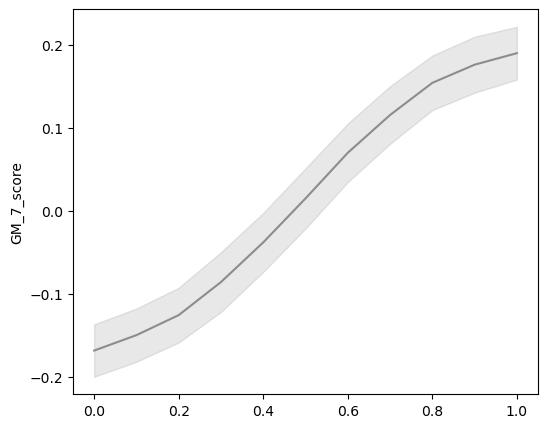

<Figure size 640x480 with 0 Axes>

In [10]:
for method in names:
    results = np.load(f'results/{method}/0_results.npz')
    
    gene_phate_op = phate.PHATE(random_state=1234, verbose=False)
    gene_data_phate = gene_phate_op.fit_transform(results['signal_embedding'])
    
    gene_clusters = np.array(leidenalg.find_partition(gene_phate_op.graph.to_igraph(), 
                                                  leidenalg.ModularityVertexPartition,
                                                  seed=0).membership)
    gene_clusters = scprep.utils.sort_clusters_by_values(gene_clusters, gene_data_phate[:, 0])

    cmap = sns.color_palette('deep', n_colors=gene_clusters.max() +1)
    
    scprep.plot.scatter2d(gene_data_phate, marker='^',
                      s=50, ticks=None, figsize=(5,5), c=gene_clusters, legend=False,
                          title=method + '\nGene Clusters', discrete=True, cmap=cmap,
                      filename=f'figures/{method}_gene_clusters.png', dpi=200)
    
    plt.show(); plt.clf()

    for c in np.unique(gene_clusters):
        scanpy.tl.score_genes(adata, gene_list=adata.var_names[gene_clusters == c],
                              random_state=0, score_name=f'GM_{c}_score',
                              n_bins=int(adata.n_vars * 0.25))

    for c in np.unique(gene_clusters):
        scprep.plot.scatter2d(true_cell_data_phate,
                      c=adata.obs[f'GM_{c}_score'], colorbar=False, s=20,
                      title=method + f'\nGene Cluster {c}', figsize=(5,5), ticks=None,
                      filename=f'figures/{method}_gene_cluster_{c}_leiden.png')
        plt.show(); plt.clf()

    for c in np.unique(gene_clusters):
        fig = plt.figure(figsize=(6,5))
        signal = adata.obs[f'GM_{c}_score']
        sns.lineplot(x=np.round(time, 1), y=signal, color=cmap[c], errorbar='sd')
        fig.savefig(f'figures/{method}_gene_cluster_{c}_over_time.png', dpi=200)
        plt.show(); plt.clf()